## Plot Oxygen data from the EGIM (EMSO Azores Observatory) using tsplot (v0.0.2)

Data downloaded from https://doi.org/10.17882/56501

In [58]:
import os 
import pandas as pd
import tsplot as ts

## Download the data

In [59]:
# Location of .csv file
datafile    = '58190.csv'
server      = "https://www.seanoe.org/data/00453/56501/data/" 

In [60]:
def getdata(serv,file,local="data"):
    import urllib.request
    if not os.path.exists('data'):os.makedirs('data')
    try:
        urllib.request.urlretrieve(os.path.join(serv,file), os.path.join(local, file) )
        urllib.request.urlcleanup()
    except:
        raise ValueError('Could not download data') 

In [61]:
print('Downloading data...')
getdata(server,datafile)
print('...done')

...done


## Load data

In [62]:
df          = pd.read_csv(os.path.join('data',datafile),skiprows=[0,2],delimiter=';')
print(list(df))

['DATE', 'TIME', 'OXYGEN', 'SATURATION', 'TEMPERATURE', 'CALPHASE', 'TCPHASE', 'C1RPH', 'C2RPH', 'C1AMP', 'C2AMP', 'RAWTEMP', 'Unnamed: 12']


Use tsplot function dt2pd() to convert the datetime format and produce a new dataframe with additional timestamps

In [63]:
dftime      = ts.time.dt2pd(df['DATE'],df['TIME'])
print(list(dftime))

['year', 'month', 'day', 'hour', 'minute', 'second', 'elapsed_1970/1/1', 'elapsed_sample', 'elapsed_month']


## Use tsplot to plot the data over the full duration of the deployment

In [64]:
'''
Plot time window
'''
startdate           = [2017,8,1]
enddate             = [2018,8,11]

Y1 =    df['OXYGEN']
Y2 =    df['TEMPERATURE']

'''
    Create X and Y array points
''' 
Y1,Xpts,xmax             = ts.time.datasync(Y1,dftime['elapsed_1970/1/1'].values,startdate,enddate)
Y2,_,_                   = ts.time.datasync(Y2,dftime['elapsed_1970/1/1'].values,startdate,enddate)

# Create ticks for Year, Month
mlabels,mlocs,ylabels,ylocs   = ts.time.ticks(startdate,enddate)

Create a scatter plot with both sets of data on the same plot

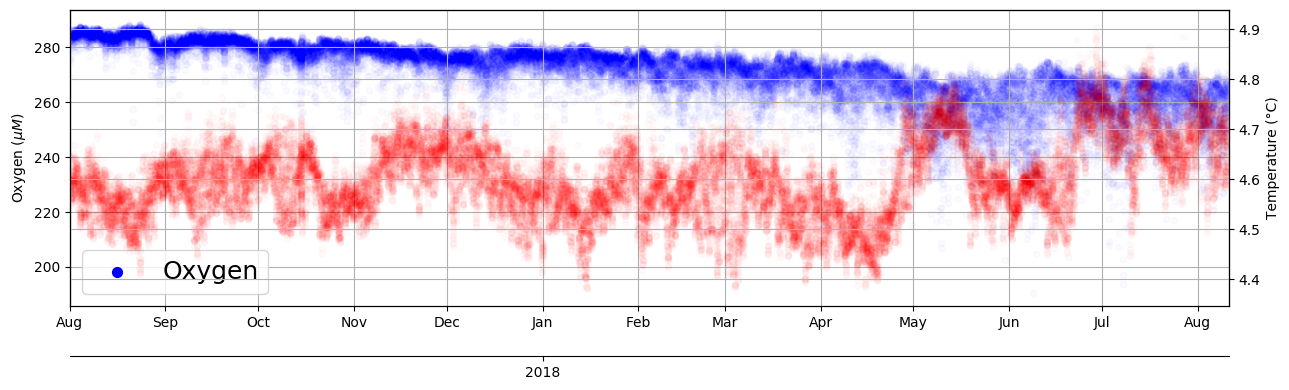

In [65]:
#Create tsplot plot class
plotter         = ts.plot.Series(
                    xlabels_l1=[mlabels,mlocs],
                    xlabels_l2=[ylabels,ylocs],
                    ylabel='Oxygen ('+ r'$\mu M$)',
                    figsize=(13,4),dpi=100)


# Second y-axis for Temperature
degree_sign = u'\N{DEGREE SIGN}'
plotter.yaxis2(label='Temperature ('+degree_sign+'C)')

# Raw data
plotter.scatter(Xpts,Y1,s=20,alpha=0.02,c='b',label='Oxygen')
plotter.scatter(Xpts,Y2,s=20,alpha=0.02,c='r',axis=2)

#Finalise Plot
plotter.xlimits(0,xmax,xlabels_l2=True)
plotter.legend(pointsize=50,linewidth=2.5)
plotter.fixplot()
plotter.show()

Apply a mean filter and add this signal to the plot.

Make sure scipy is installed:

pip install scipy

In [66]:
import numpy as np
import scipy.ndimage as ndimage 

In [67]:
def mean(arr,window=7):
    '''
        Apply a mean filter by averaging values in the 
        given window
    '''
    assert (window-1)%2==0,'window must be odd'
    kernel  = np.array(np.ones(int(window)))
    kernel  = np.divide(kernel,float(np.sum(kernel)))
    return ndimage.convolve(arr,kernel) 

The frequency of samples in the data is approximately 15 minutes apart (900 seconds). We can see this from the dftime DataFrame...

In [68]:
print(dftime.elapsed_sample[0:5])

0       0.0
1     900.0
2    1799.0
3    2699.0
4    3599.0
Name: elapsed_sample, dtype: float64


So the number of samples in one day can be given by:

In [69]:
daysamples = ((3600*24)/900)+1

as there are 3600 seconds in one hour, 24 hours in a day, and 900 seconds between each sample. Adding 1 allows us to centre the filter over each sample point by making the window size an odd number.

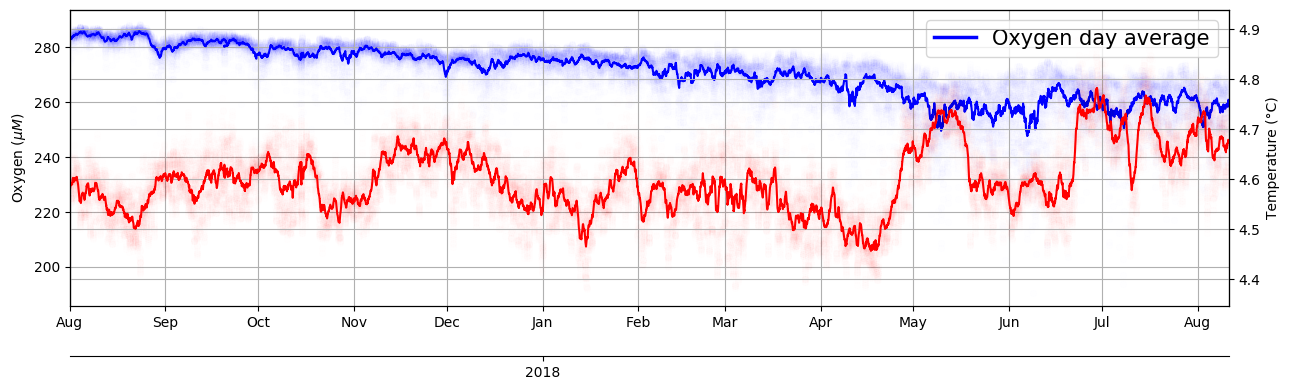

In [70]:
#Create tsplot plot class
plotter         = ts.plot.Series(
                    xlabels_l1=[mlabels,mlocs],
                    xlabels_l2=[ylabels,ylocs],
                    ylabel='Oxygen ('+ r'$\mu M$)',
                    figsize=(13,4),dpi=100)


# Second y-axis for Temperature
degree_sign = u'\N{DEGREE SIGN}'
plotter.yaxis2(label='Temperature ('+degree_sign+'C)')

# Raw data
plotter.scatter(Xpts,Y1,s=20,alpha=0.0025,c='b')
plotter.scatter(Xpts,Y2,s=20,alpha=0.0025,c='r',axis=2)
# Daily average- number of samples in one day
Y1daily     = mean(Y1,window=daysamples)
Y2daily     = mean(Y2,window=daysamples)
plotter.line(Xpts,Y1daily,linewidth=1.5,alpha=1,c='b', label='Oxygen day average')
plotter.line(Xpts,Y2daily,linewidth=1.5,alpha=1,c='r', label='Temperature day average',axis=2)

#Finalise Plot
plotter.legend(fontsize=15,linewidth=2.5)
plotter.xlimits(0,xmax,xlabels_l2=True)
plotter.fixplot()
plotter.show()

*Note that tsplot v0.0.2 doesn't produce a legend for the second y-axis. This will be fixed in a later version

We can also use tsplot to plot these signals within two subplots using the SeriesSub class

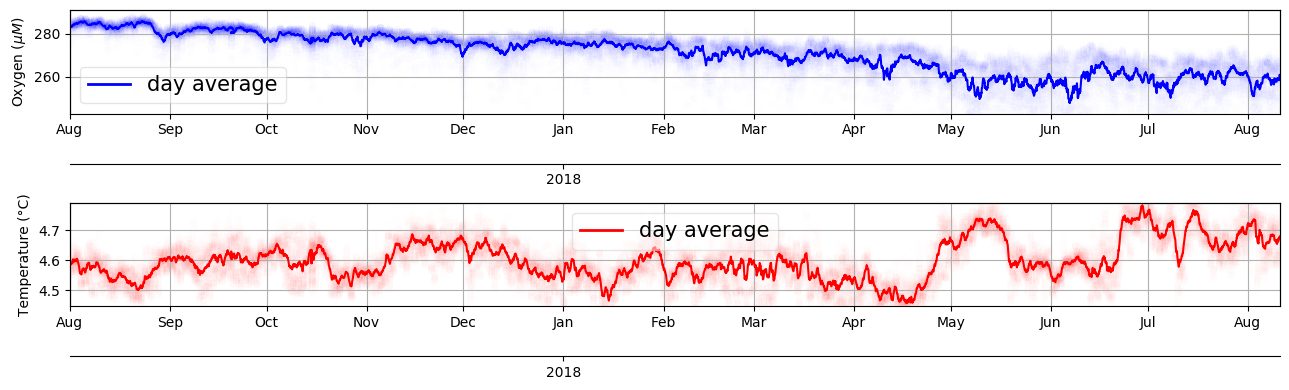

In [71]:
#Create timsie plot class
plotter         = ts.plot.SeriesSub(
                    xlabels_l1=[mlabels,mlocs],
                    xlabels_l2=[ylabels,ylocs],
                    sub1=2,
                    figsize=(13,4),dpi=100)


degree_sign = u'\N{DEGREE SIGN}'

## First plot
plotter.set_ylabel('Oxygen ('+ r'$\mu M$)')
plotter.scatter(Xpts,Y1,s=20,alpha=0.0025,c='b')
Y1daily     = mean(Y1,window=daysamples)
plotter.line(Xpts,Y1daily,linewidth=1.5,alpha=1,c='b', label='day average')
plotter.xlimits(0,xmax,xlabels_l2=True)
plotter.ylimits(np.min(Y1daily)-5,np.max(Y1daily)+5,plot=0)
plotter.legend(fontsize=15,linewidth=2)

# Second plot
plotter.set_ylabel('Temperature ('+degree_sign+'C)',plot=1)
plotter.labelmatch() # match the xticks
plotter.scatter(Xpts,Y2,s=20,alpha=0.0025,c='r',plot=1)
Y2daily     = mean(Y2,window=daysamples)
plotter.line(Xpts,Y2daily,c='r',linewidth=1.5,plot=1,label='day average')
plotter.xlimits(0,xmax,xlabels_l2=True,plot=1)
plotter.ylimits(np.min(Y2daily)-0.01,np.max(Y2daily)+0.01,plot=1)
plotter.legend(fontsize=15,linewidth=2,plot=1)

#Finalise Plot
plotter.xlimits(0,xmax,xlabels_l2=True)
plotter.fixplot()
plotter.show()

## Create plots with a finer time intervals
### 2 month window

In [72]:
startdate           = [2018,1,1]
enddate             = [2018,3,1]

'''
    Create X and Y array points
''' 
Y1,Xpts,xmax             = ts.time.datasync(Y1,dftime['elapsed_1970/1/1'].values,startdate,enddate)
Y2,_,_                   = ts.time.datasync(Y2,dftime['elapsed_1970/1/1'].values,startdate,enddate)

# Create ticks for Year, Month
dlabels,dlocs,mlabels,mlocs   = ts.time.ticks(startdate,enddate,yearticks=False,dayticks=True)
# Remove some tick labels 
for i in np.arange(1,len(dlabels),2):
    dlabels[i] = ''

total days:  59
days in first month: : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
delay for first day index:  0
time past in day:  0


*some debugging information is printed in tsplot v0.0.2 when creating day ticks - this will be removed in a later version

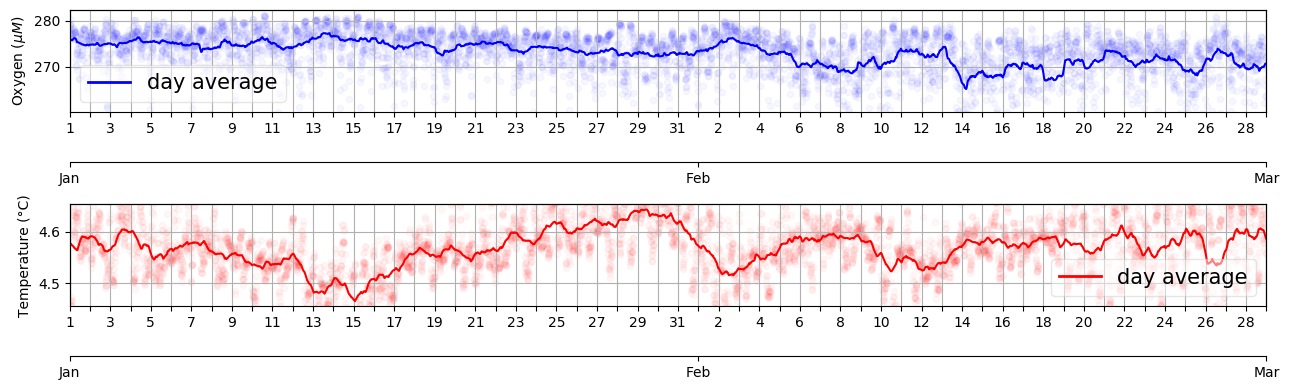

In [73]:
#Create tsplot plot class
plotter         = ts.plot.SeriesSub(
                    xlabels_l1=[dlabels,dlocs],
                    xlabels_l2=[mlabels,mlocs],
                    sub1=2,
                    figsize=(13,4),dpi=100)


degree_sign = u'\N{DEGREE SIGN}'

## First plot
plotter.set_ylabel('Oxygen ('+ r'$\mu M$)')
plotter.scatter(Xpts,Y1,s=20,alpha=0.03,c='b')
Y1daily     = mean(Y1,window=daysamples)
plotter.line(Xpts,Y1daily,linewidth=1.5,alpha=1,c='b', label='day average')
plotter.xlimits(0,xmax,xlabels_l2=True)
plotter.ylimits(np.min(Y1daily)-5,np.max(Y1daily)+5,plot=0)
plotter.legend(fontsize=15,linewidth=2)

# Second plot
plotter.set_ylabel('Temperature ('+degree_sign+'C)',plot=1)
plotter.labelmatch() # match the xticks
plotter.scatter(Xpts,Y2,s=20,alpha=0.03,c='r',plot=1)
Y2daily     = mean(Y2,window=daysamples)
plotter.line(Xpts,Y2daily,c='r',linewidth=1.5,plot=1,label='day average')
plotter.xlimits(0,xmax,xlabels_l2=True,plot=1)
plotter.ylimits(np.min(Y2daily)-0.01,np.max(Y2daily)+0.01,plot=1)
plotter.legend(fontsize=15,linewidth=2,plot=1)

#Finalise Plot
plotter.fixplot()
plotter.show()

### 8 day window
Here we use a one hour window for filtering and use the overlap argument to include additional samples at the borders to reduce artfacts being created at the start and end of the plotted series.

In [74]:
hoursamples = (3600/900)+1

In [77]:
startdate           = [2018,1,27]
enddate             = [2018,2,4]

'''
    Create X and Y array points
''' 
Y1,Xpts,xmax             = ts.time.datasync(Y1,dftime['elapsed_1970/1/1'].values,startdate,enddate,overlap=20)
Y2,_,_                   = ts.time.datasync(Y2,dftime['elapsed_1970/1/1'].values,startdate,enddate,overlap=20)

# Create ticks for Year, Month
hlabels,hlocs,dlabels,dlocs,mlabels,mlocs   = ts.time.ticks(startdate,enddate,yearticks=False,dayticks=True,timeticks=True)
# Remove some tick labels 
rmlen   = 12 # keep every # labels
offset  = 6
hlabels_subset, hlocs_subset = [],[]
for i in range(len(hlabels)-offset):
    if i % rmlen ==0:
        hlabels_subset.append(hlabels[i+offset])
        hlocs_subset.append(hlocs[i+offset])

total days:  8
days in first month: : [27, 28, 29, 30, 31]
delay for first day index:  0
time past in day:  0


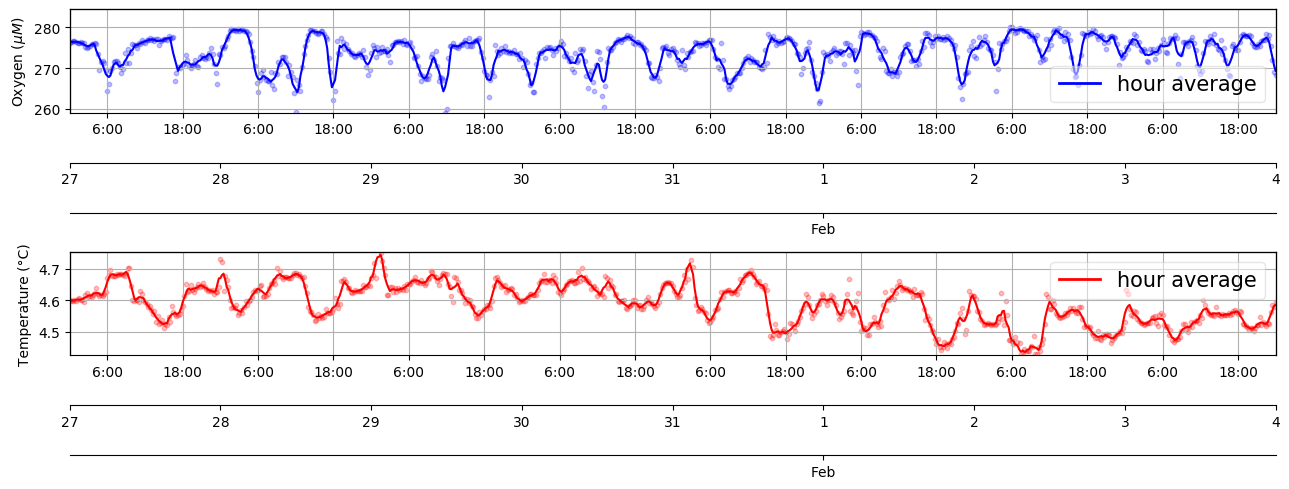

In [78]:
#Create tsplot plot class
plotter         = ts.plot.SeriesSub(
                    xlabels_l1=[hlabels_subset,hlocs_subset],
                    xlabels_l2=[dlabels,dlocs],
                    xlabels_l3=[mlabels,mlocs],
                    sub1=2,
                    figsize=(13,5),dpi=100)


degree_sign = u'\N{DEGREE SIGN}'

## First plot
plotter.set_ylabel('Oxygen ('+ r'$\mu M$)')
plotter.scatter(Xpts,Y1,s=10,alpha=0.25,c='b')
Y1hour     = mean(Y1,window=hoursamples)
plotter.line(Xpts,Y1hour,linewidth=1.5,alpha=1,c='b', label='hour average')
plotter.xlimits(0,xmax,xlabels_l2=True,xlabels_l3=True)
plotter.ylimits(np.min(Y1hour)-5,np.max(Y1hour)+5,plot=0)
plotter.legend(fontsize=15,linewidth=2)

# Second plot
plotter.set_ylabel('Temperature ('+degree_sign+'C)',plot=1)
plotter.labelmatch() # match the xticks
plotter.scatter(Xpts,Y2,s=10,alpha=0.25,c='r',plot=1)
Y2hour     = mean(Y2,window=hoursamples)
plotter.line(Xpts,Y2hour,c='r',linewidth=1.5,plot=1,label='hour average')
plotter.xlimits(0,xmax,xlabels_l2=True,xlabels_l3=True,plot=1)
plotter.ylimits(np.min(Y2hour)-0.01,np.max(Y2hour)+0.01,plot=1)
plotter.legend(fontsize=15,linewidth=2,plot=1)

#Finalise Plot
plotter.fixplot()
plotter.show()